# MRI重建流程：K空间成像与欠采样重建

本Notebook实现MRI重建的完整流程，包括：

1. **K空间基础**：图像与K空间的FFT/IFFT关系
2. **采样策略**：完全采样、欠采样（行采样、中心采样、径向采样）
3. **重建算法**：直接IFFT、零填充、POCS迭代重建
4. **后处理**：K空间滤波、图像域去噪
5. **质量评估**：PSNR、SSIM、NMSE等指标

## 依赖项

- numpy >= 1.20.0
- matplotlib >= 3.3.0
- scikit-image >= 0.18.0
- scipy >= 1.6.0

## 1. 环境配置与导入

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.data import shepp_logan_phantom, camera
from skimage.transform import resize
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
from scipy.ndimage import gaussian_filter
import warnings
warnings.filterwarnings('ignore')

# 设置随机种子
np.random.seed(42)

# 图像大小
img_size = 256

print("环境配置完成！")
print(f"图像大小: {img_size}x{img_size}")

环境配置完成！
图像大小: 256x256


## 2. K空间基础

理解图像域与K空间的对应关系：
- **图像域**：空间域，表示组织的空间分布
- **K空间**：频率域，包含图像的频率信息
- **中心区域**：对应低频信息（对比度）
- **外围区域**：对应高频信息（细节/边缘）

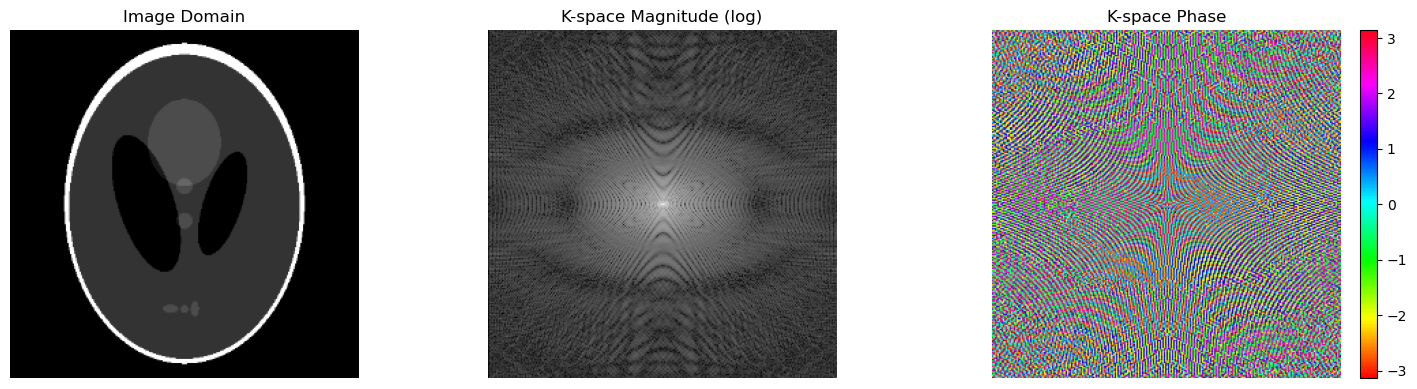

✓ K空间基础可视化完成


In [2]:
# 加载测试图像
img = resize(shepp_logan_phantom(), (img_size, img_size), mode='constant', anti_aliasing=True)

# 图像域 -> K空间 (2D FFT)
k_space = np.fft.fftshift(np.fft.fft2(img))

# K空间幅度（对数尺度便于可视化）
k_magnitude = np.log1p(np.abs(k_space))

# K空间相位
k_phase = np.angle(k_space)

# 可视化
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].imshow(img, cmap='gray')
axes[0].set_title('Image Domain')
axes[0].axis('off')

axes[1].imshow(k_magnitude, cmap='gray')
axes[1].set_title('K-space Magnitude (log)')
axes[1].axis('off')

im = axes[2].imshow(k_phase, cmap='hsv', vmin=-np.pi, vmax=np.pi)
axes[2].set_title('K-space Phase')
axes[2].axis('off')
plt.colorbar(im, ax=axes[2], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.savefig('output/01_kspace_basics.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ K空间基础可视化完成")

## 3. 完全采样重建

使用完整的K空间数据进行重建，作为金标准。

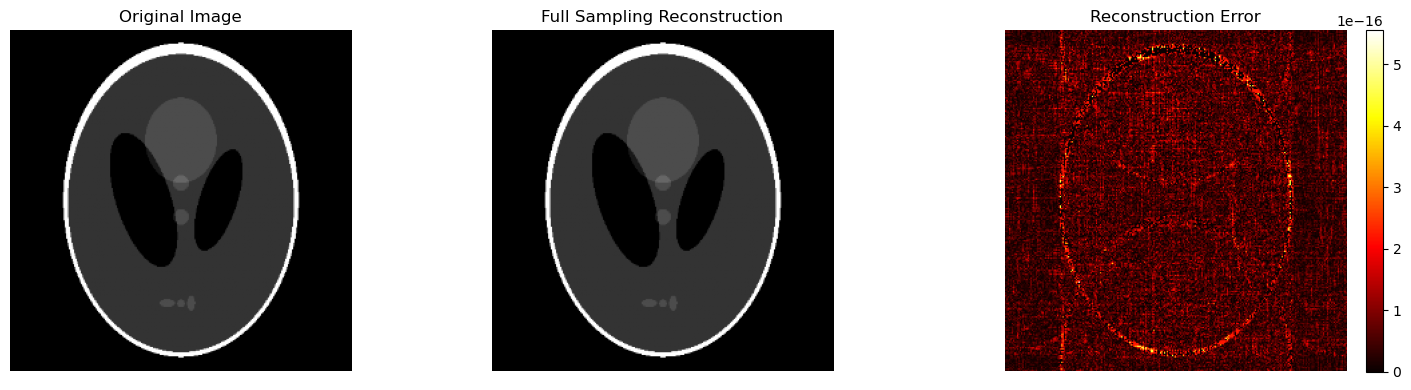

✓ 完全采样重建完成
  PSNR: 322.69 dB
  SSIM: 1.0000
  NMSE: 0.000000


In [3]:
# K空间 -> 图像域 (2D IFFT)
recon_full = np.fft.ifft2(np.fft.ifftshift(k_space))
recon_full = np.real(recon_full)

# 计算重建误差
error = np.abs(img - recon_full)

# 可视化
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].imshow(img, cmap='gray')
axes[0].set_title('Original Image')
axes[0].axis('off')

axes[1].imshow(recon_full, cmap='gray')
axes[1].set_title('Full Sampling Reconstruction')
axes[1].axis('off')

im = axes[2].imshow(error, cmap='hot')
axes[2].set_title('Reconstruction Error')
axes[2].axis('off')
plt.colorbar(im, ax=axes[2], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.savefig('output/02_full_sampling_recon.png', dpi=150, bbox_inches='tight')
plt.show()

# 计算质量指标
psnr_full = peak_signal_noise_ratio(img, recon_full, data_range=1.0)
ssim_full = structural_similarity(img, recon_full, data_range=1.0)
nmse_full = np.mean((img - recon_full)**2) / np.mean(img**2)

print(f"✓ 完全采样重建完成")
print(f"  PSNR: {psnr_full:.2f} dB")
print(f"  SSIM: {ssim_full:.4f}")
print(f"  NMSE: {nmse_full:.6f}")

## 4. 欠采样策略

MRI中为了减少扫描时间，常采用欠采样策略。这里模拟几种常见的欠采样方式。

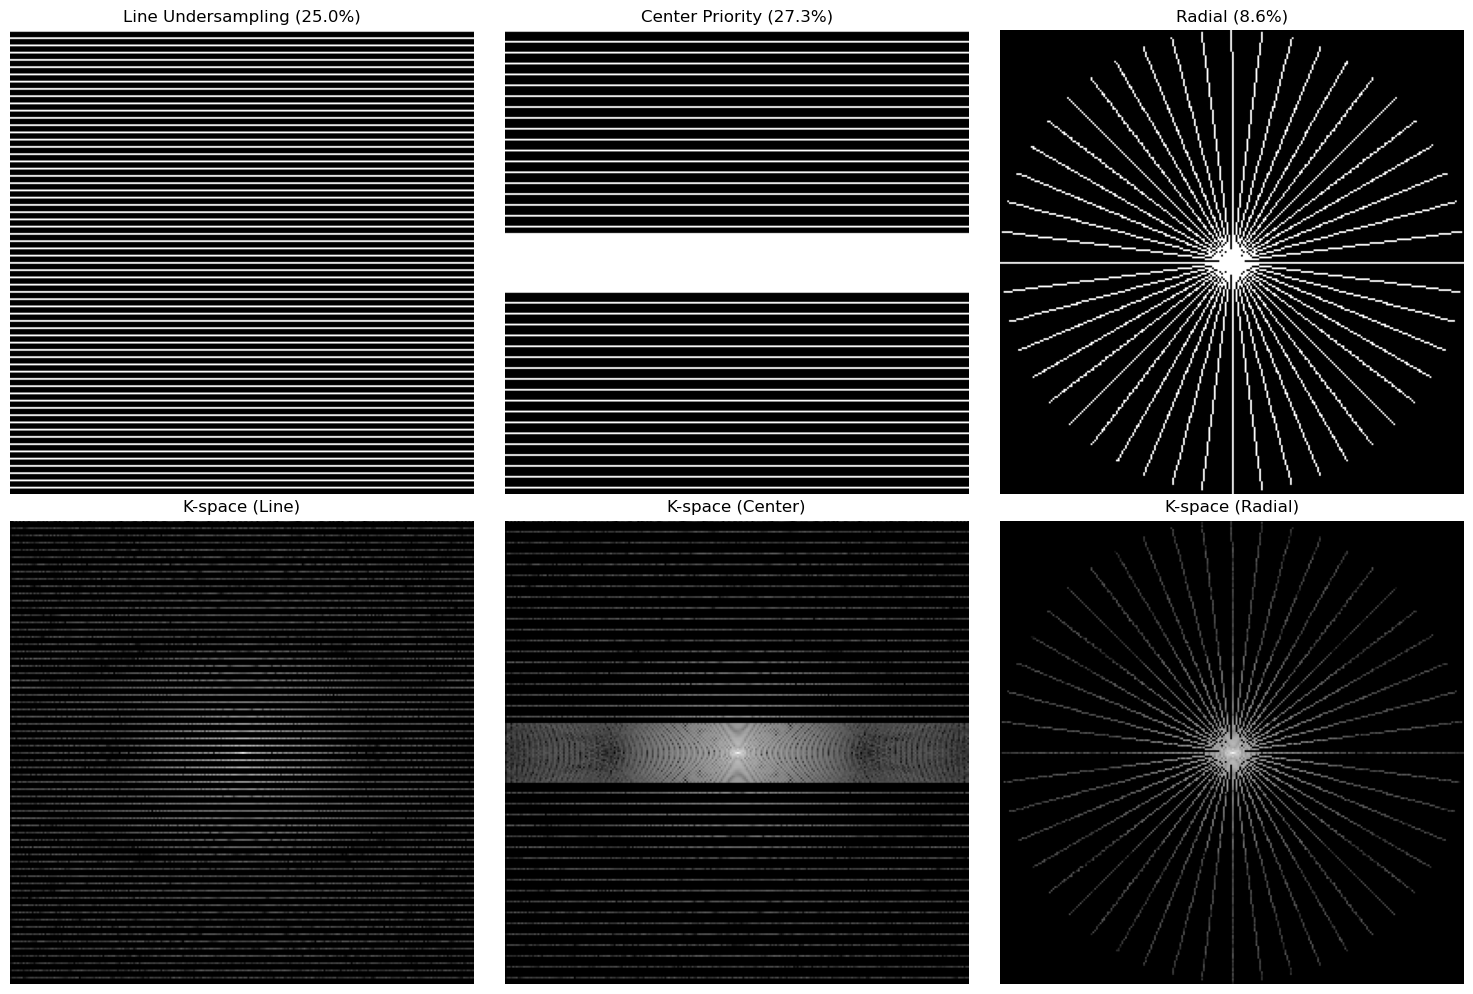

✓ 采样策略可视化完成


In [4]:
# ========== 策略1: 行欠采样（均匀欠采样） ==========
def create_line_undersampling_mask(size, factor):
    """创建行欠采样掩码"""
    mask = np.zeros((size, size), dtype=bool)
    mask[::factor, :] = True
    return mask

# ========== 策略2: 中心优先采样 ==========
def create_center_sampling_mask(size, center_lines, outer_factor):
    """创建中心优先采样掩码"""
    mask = np.zeros((size, size), dtype=bool)
    center_start = (size - center_lines) // 2
    mask[center_start:center_start+center_lines, :] = True
    # 外围均匀采样
    outer_indices = list(range(0, center_start, outer_factor)) + \
                    list(range(center_start+center_lines, size, outer_factor))
    mask[outer_indices, :] = True
    return mask

# ========== 策略3: 径向采样 ==========
def create_radial_sampling_mask(size, n_spokes):
    """创建径向采样掩码"""
    mask = np.zeros((size, size), dtype=bool)
    center = size // 2
    angles = np.linspace(0, np.pi, n_spokes, endpoint=False)
    
    for angle in angles:
        for r in range(size):
            x = int(center + (r - center) * np.cos(angle))
            y = int(center + (r - center) * np.sin(angle))
            if 0 <= x < size and 0 <= y < size:
                mask[y, x] = True
    return mask

# 创建不同采样掩码
mask_line = create_line_undersampling_mask(img_size, 4)
mask_center = create_center_sampling_mask(img_size, 32, 6)
mask_radial = create_radial_sampling_mask(img_size, 24)

# 计算采样率
rate_line = np.sum(mask_line) / mask_line.size * 100
rate_center = np.sum(mask_center) / mask_center.size * 100
rate_radial = np.sum(mask_radial) / mask_radial.size * 100

# 可视化采样掩码
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# 第一行：采样掩码
axes[0, 0].imshow(mask_line, cmap='gray')
axes[0, 0].set_title(f'Line Undersampling ({rate_line:.1f}%)')
axes[0, 0].axis('off')

axes[0, 1].imshow(mask_center, cmap='gray')
axes[0, 1].set_title(f'Center Priority ({rate_center:.1f}%)')
axes[0, 1].axis('off')

axes[0, 2].imshow(mask_radial, cmap='gray')
axes[0, 2].set_title(f'Radial ({rate_radial:.1f}%)')
axes[0, 2].axis('off')

# 第二行：对应的K空间
k_line = k_space * mask_line
k_center = k_space * mask_center
k_radial = k_space * mask_radial

axes[1, 0].imshow(np.log1p(np.abs(k_line)), cmap='gray')
axes[1, 0].set_title('K-space (Line)')
axes[1, 0].axis('off')

axes[1, 1].imshow(np.log1p(np.abs(k_center)), cmap='gray')
axes[1, 1].set_title('K-space (Center)')
axes[1, 1].axis('off')

axes[1, 2].imshow(np.log1p(np.abs(k_radial)), cmap='gray')
axes[1, 2].set_title('K-space (Radial)')
axes[1, 2].axis('off')

plt.tight_layout()
plt.savefig('output/03_sampling_masks.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ 采样策略可视化完成")

## 5. 欠采样重建与伪影分析

直接对欠采样的K空间进行IFFT重建，观察产生的伪影。

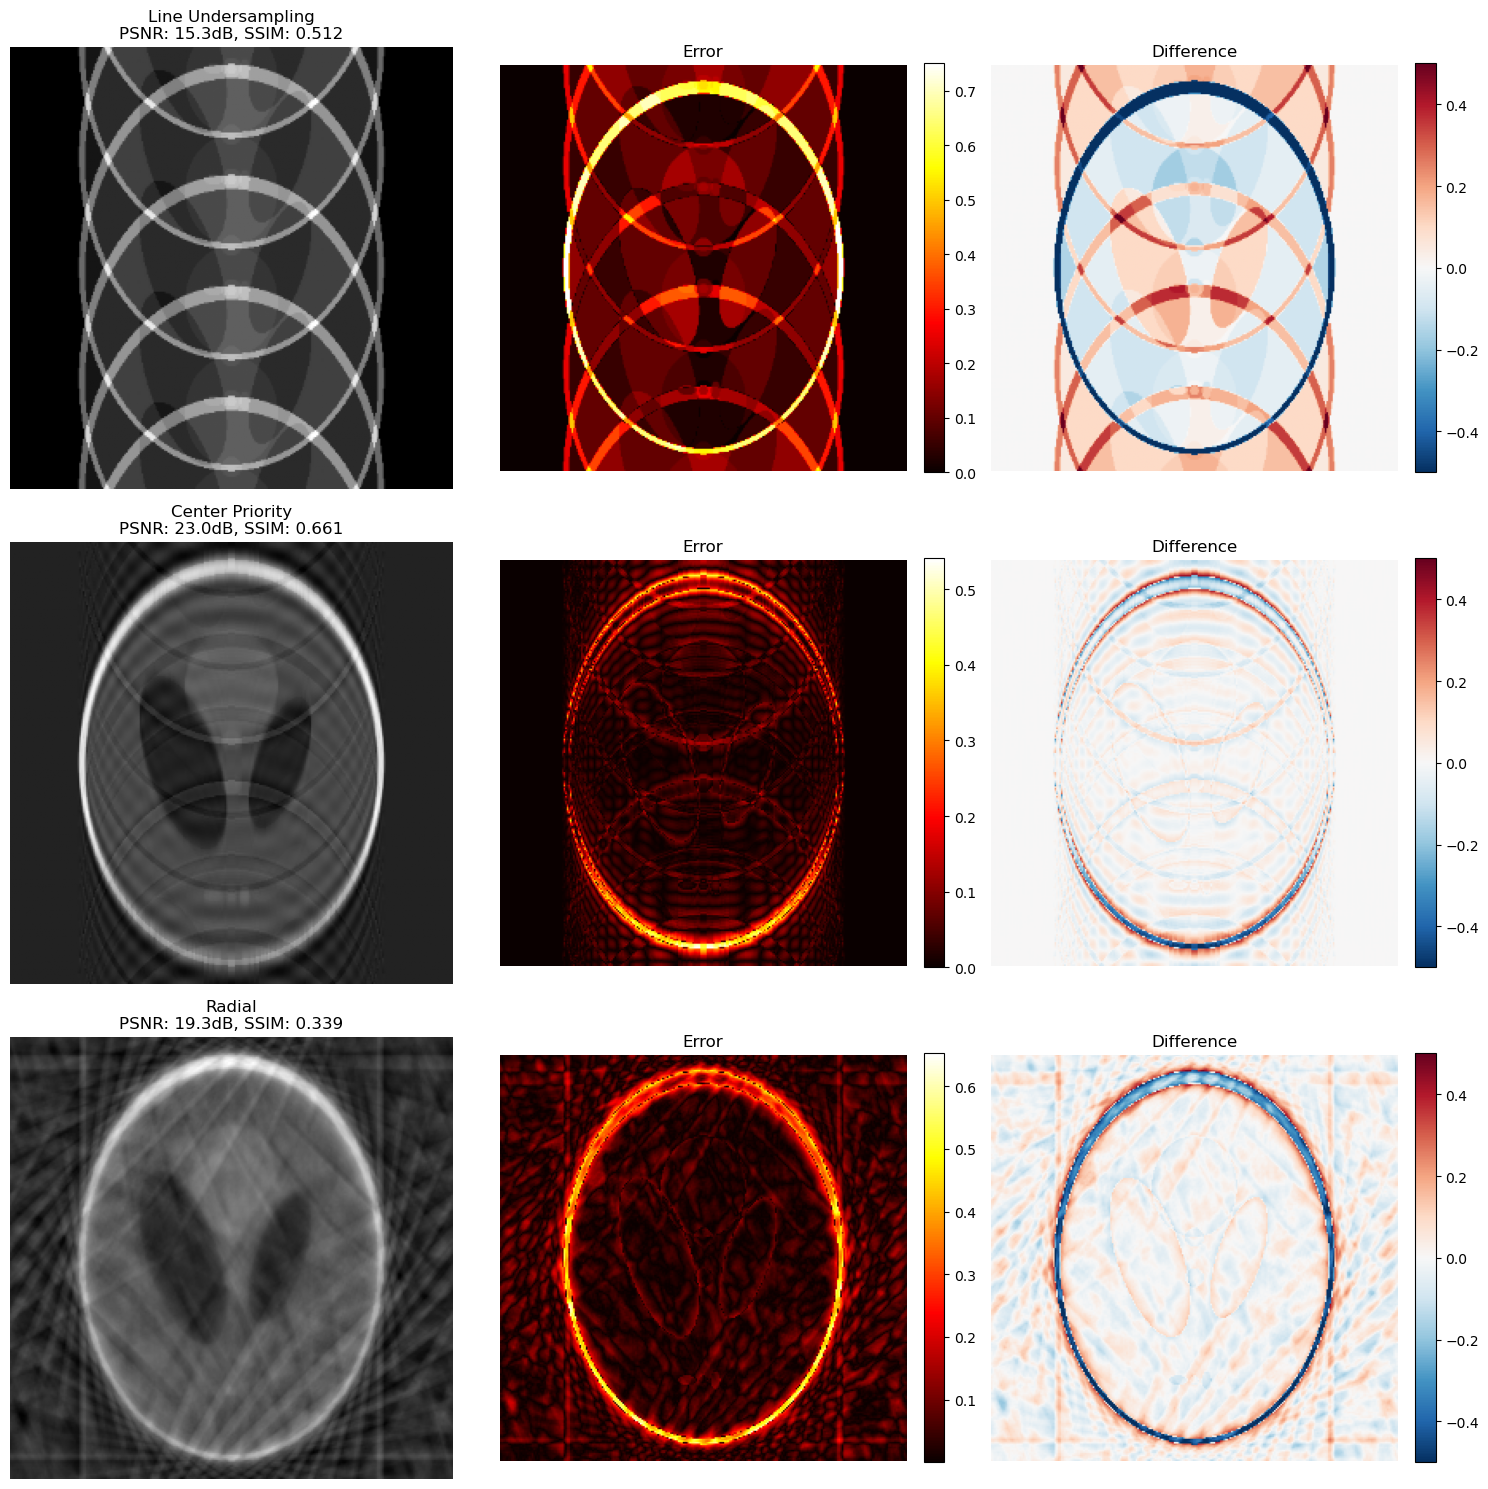

✓ 欠采样重建与伪影分析完成


In [5]:
# 直接IFFT重建（零填充）
recon_line = np.real(np.fft.ifft2(np.fft.ifftshift(k_line)))
recon_center = np.real(np.fft.ifft2(np.fft.ifftshift(k_center)))
recon_radial = np.real(np.fft.ifft2(np.fft.ifftshift(k_radial)))

# 计算误差
error_line = np.abs(img - recon_line)
error_center = np.abs(img - recon_center)
error_radial = np.abs(img - recon_radial)

# 计算质量指标
psnr_line = peak_signal_noise_ratio(img, recon_line, data_range=1.0)
psnr_center = peak_signal_noise_ratio(img, recon_center, data_range=1.0)
psnr_radial = peak_signal_noise_ratio(img, recon_radial, data_range=1.0)

ssim_line = structural_similarity(img, recon_line, data_range=1.0)
ssim_center = structural_similarity(img, recon_center, data_range=1.0)
ssim_radial = structural_similarity(img, recon_radial, data_range=1.0)

# 可视化
fig, axes = plt.subplots(3, 3, figsize=(15, 15))

recons = [recon_line, recon_center, recon_radial]
errors = [error_line, error_center, error_radial]
titles = ['Line Undersampling', 'Center Priority', 'Radial']
psnrs = [psnr_line, psnr_center, psnr_radial]
ssims = [ssim_line, ssim_center, ssim_radial]

for i in range(3):
    # 重建图像
    axes[i, 0].imshow(recons[i], cmap='gray')
    axes[i, 0].set_title(f'{titles[i]}\nPSNR: {psnrs[i]:.1f}dB, SSIM: {ssims[i]:.3f}')
    axes[i, 0].axis('off')
    
    # 误差图
    im = axes[i, 1].imshow(errors[i], cmap='hot')
    axes[i, 1].set_title('Error')
    axes[i, 1].axis('off')
    plt.colorbar(im, ax=axes[i, 1], fraction=0.046, pad=0.04)
    
    # 伪影分析（与原始图像的差值）
    im2 = axes[i, 2].imshow(recons[i] - img, cmap='RdBu_r', vmin=-0.5, vmax=0.5)
    axes[i, 2].set_title('Difference')
    axes[i, 2].axis('off')
    plt.colorbar(im2, ax=axes[i, 2], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.savefig('output/04_undersampling_artifacts.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ 欠采样重建与伪影分析完成")

## 6. 迭代重建：POCS算法

POCS (Projection Onto Convex Sets) 是一种常用的迭代重建算法，通过交替投影到数据一致性和稀疏性约束上来改善欠采样重建质量。

In [6]:
def pocs_reconstruction(k_undersampled, mask, n_iterations=50, lambda_reg=0.01):
    """
    POCS迭代重建
    
    Parameters:
    -----------
    k_undersampled : ndarray
        欠采样的K空间数据
    mask : ndarray
        采样掩码
    n_iterations : int
        迭代次数
    lambda_reg : float
        正则化参数
    
    Returns:
    --------
    recon : ndarray
        重建图像
    """
    # 初始估计（零填充重建）
    x = np.real(np.fft.ifft2(np.fft.ifftshift(k_undersampled)))
    
    for _ in range(n_iterations):
        # 步骤1: 变换到K空间
        k = np.fft.fftshift(np.fft.fft2(x))
        
        # 步骤2: 数据一致性投影（保持采样点不变）
        k = k * ~mask + k_undersampled
        
        # 步骤3: 变换回图像域
        x = np.real(np.fft.ifft2(np.fft.ifftshift(k)))
        
        # 步骤4: 稀疏性约束（软阈值）
        x = np.sign(x) * np.maximum(np.abs(x) - lambda_reg, 0)
    
    return x

# 应用POCS重建
print("正在执行POCS重建...")

recon_pocs_line = pocs_reconstruction(k_line, mask_line, n_iterations=30)
recon_pocs_center = pocs_reconstruction(k_center, mask_center, n_iterations=30)

# 计算质量指标
psnr_pocs_line = peak_signal_noise_ratio(img, recon_pocs_line, data_range=1.0)
psnr_pocs_center = peak_signal_noise_ratio(img, recon_pocs_center, data_range=1.0)

ssim_pocs_line = structural_similarity(img, recon_pocs_line, data_range=1.0)
ssim_pocs_center = structural_similarity(img, recon_pocs_center, data_range=1.0)

print(f"✓ POCS重建完成")
print(f"  Line: PSNR={psnr_pocs_line:.2f}dB, SSIM={ssim_pocs_line:.4f}")
print(f"  Center: PSNR={psnr_pocs_center:.2f}dB, SSIM={ssim_pocs_center:.4f}")

正在执行POCS重建...


✓ POCS重建完成
  Line: PSNR=15.31dB, SSIM=0.5056
  Center: PSNR=26.29dB, SSIM=0.7829


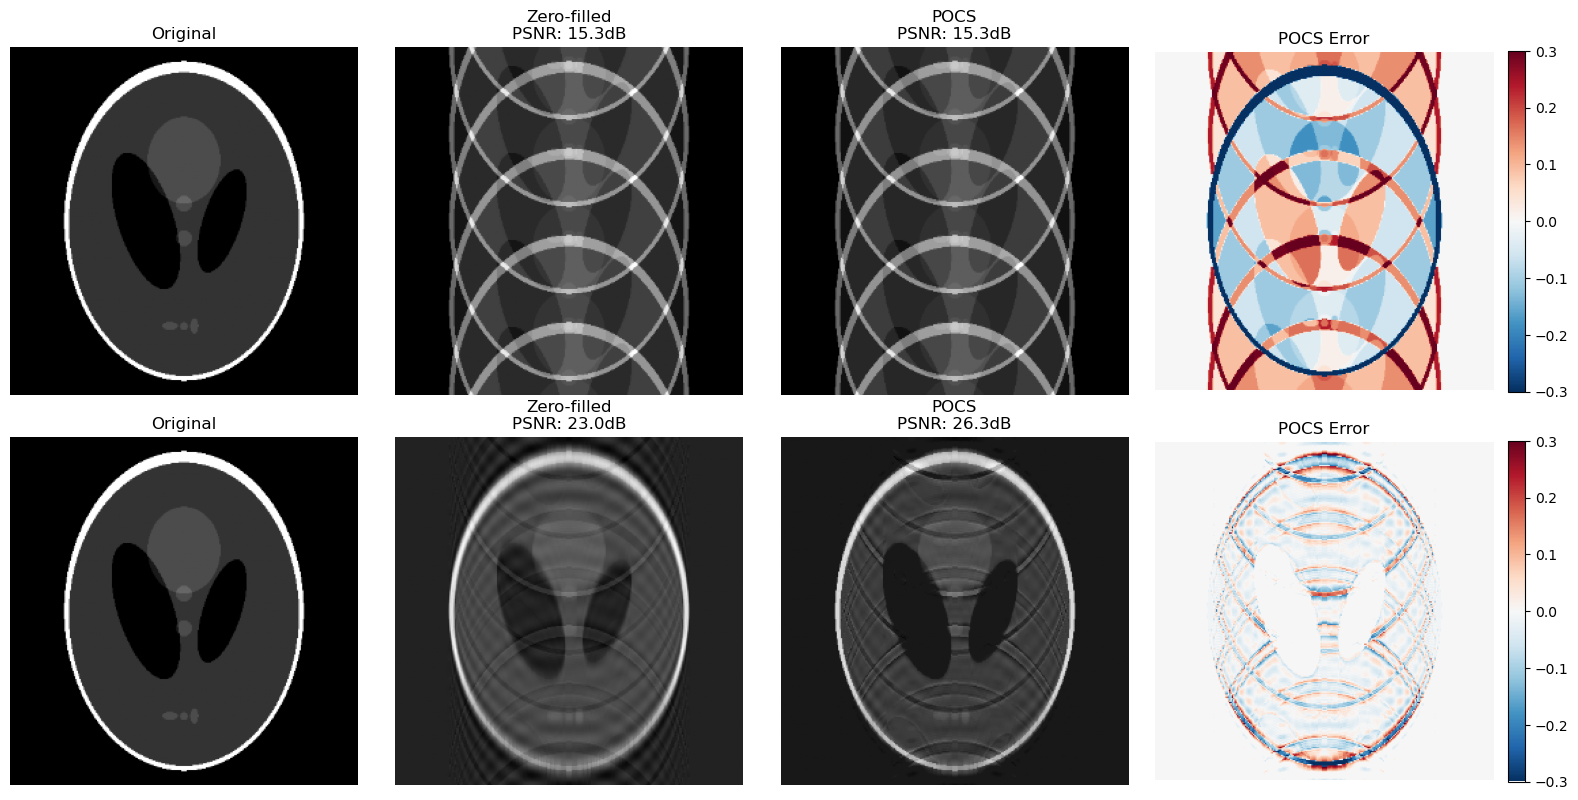

✓ POCS重建可视化完成


In [7]:
# 可视化POCS重建结果
fig, axes = plt.subplots(2, 4, figsize=(16, 8))

# 行欠采样对比
axes[0, 0].imshow(img, cmap='gray')
axes[0, 0].set_title('Original')
axes[0, 0].axis('off')

axes[0, 1].imshow(recon_line, cmap='gray')
axes[0, 1].set_title(f'Zero-filled\nPSNR: {psnr_line:.1f}dB')
axes[0, 1].axis('off')

axes[0, 2].imshow(recon_pocs_line, cmap='gray')
axes[0, 2].set_title(f'POCS\nPSNR: {psnr_pocs_line:.1f}dB')
axes[0, 2].axis('off')

im1 = axes[0, 3].imshow(recon_pocs_line - img, cmap='RdBu_r', vmin=-0.3, vmax=0.3)
axes[0, 3].set_title('POCS Error')
axes[0, 3].axis('off')
plt.colorbar(im1, ax=axes[0, 3], fraction=0.046, pad=0.04)

# 中心采样对比
axes[1, 0].imshow(img, cmap='gray')
axes[1, 0].set_title('Original')
axes[1, 0].axis('off')

axes[1, 1].imshow(recon_center, cmap='gray')
axes[1, 1].set_title(f'Zero-filled\nPSNR: {psnr_center:.1f}dB')
axes[1, 1].axis('off')

axes[1, 2].imshow(recon_pocs_center, cmap='gray')
axes[1, 2].set_title(f'POCS\nPSNR: {psnr_pocs_center:.1f}dB')
axes[1, 2].axis('off')

im2 = axes[1, 3].imshow(recon_pocs_center - img, cmap='RdBu_r', vmin=-0.3, vmax=0.3)
axes[1, 3].set_title('POCS Error')
axes[1, 3].axis('off')
plt.colorbar(im2, ax=axes[1, 3], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.savefig('output/05_pocs_reconstruction.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ POCS重建可视化完成")

## 7. K空间滤波

在K空间应用滤波器可以改善重建图像质量。

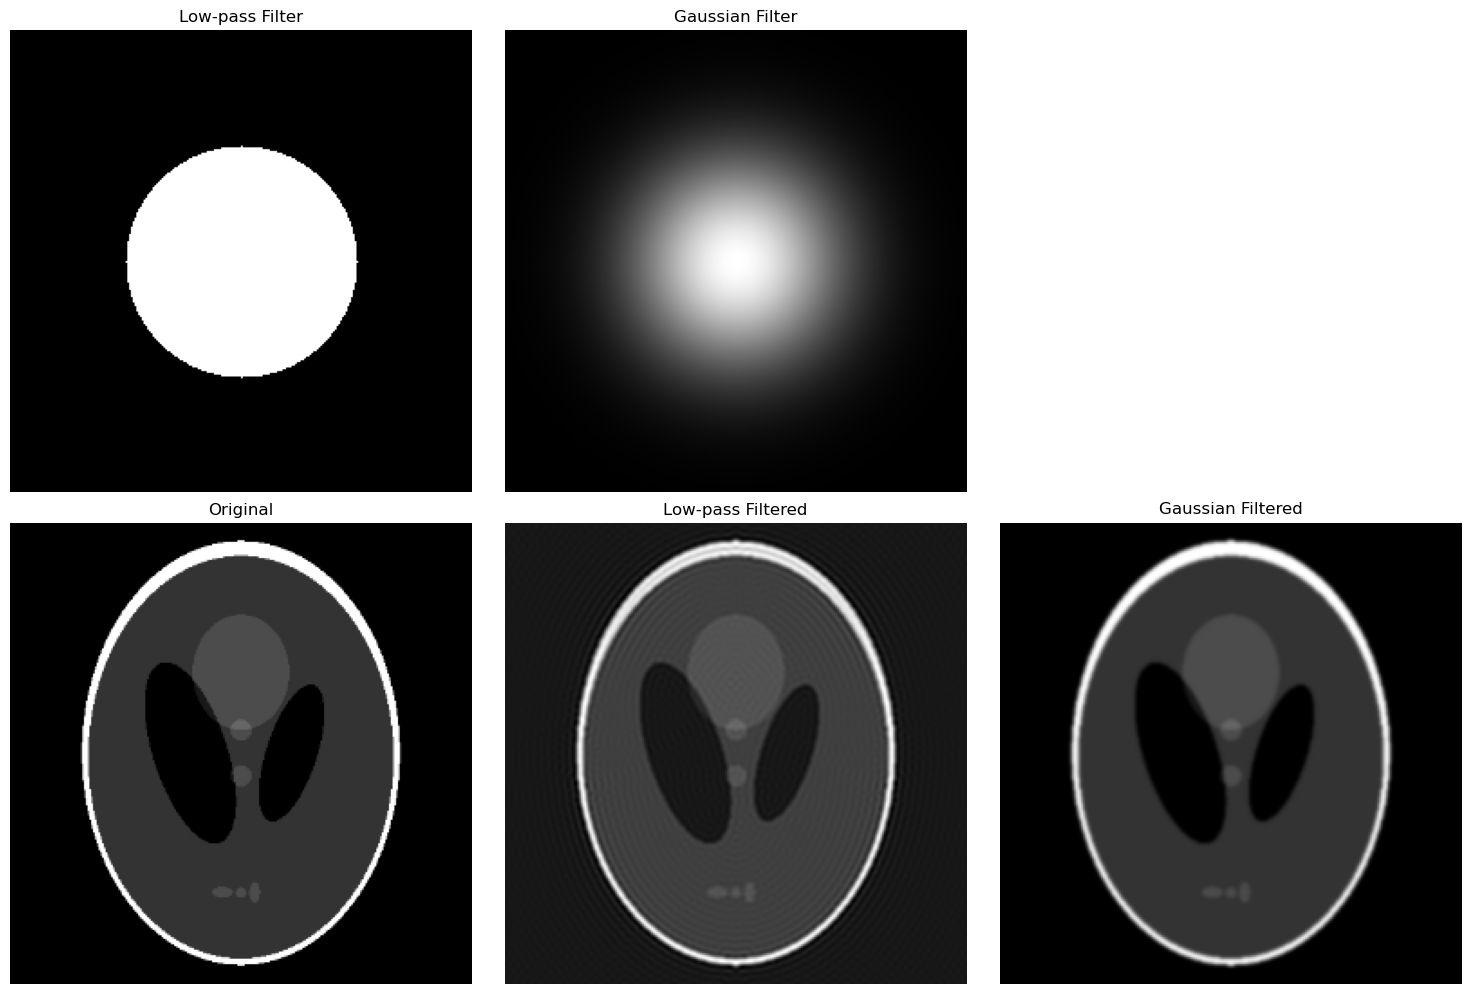

✓ K空间滤波完成


In [8]:
# 创建K空间滤波器
def create_lowpass_filter(size, cutoff):
    """创建理想低通滤波器"""
    y, x = np.ogrid[-size//2:size//2, -size//2:size//2]
    r = np.sqrt(x**2 + y**2)
    return r <= cutoff

def create_gaussian_filter(size, sigma):
    """创建高斯滤波器"""
    y, x = np.ogrid[-size//2:size//2, -size//2:size//2]
    r = x**2 + y**2
    return np.exp(-r / (2 * sigma**2))

# 创建滤波器
lp_filter = create_lowpass_filter(img_size, 64)
gauss_filter = create_gaussian_filter(img_size, 40)

# 应用滤波器
k_lp = k_space * lp_filter
k_gauss = k_space * gauss_filter

recon_lp = np.real(np.fft.ifft2(np.fft.ifftshift(k_lp)))
recon_gauss = np.real(np.fft.ifft2(np.fft.ifftshift(k_gauss)))

# 可视化
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# 滤波器
axes[0, 0].imshow(lp_filter, cmap='gray')
axes[0, 0].set_title('Low-pass Filter')
axes[0, 0].axis('off')

axes[0, 1].imshow(gauss_filter, cmap='gray')
axes[0, 1].set_title('Gaussian Filter')
axes[0, 1].axis('off')

axes[0, 2].axis('off')

# 重建结果
axes[1, 0].imshow(img, cmap='gray')
axes[1, 0].set_title('Original')
axes[1, 0].axis('off')

axes[1, 1].imshow(recon_lp, cmap='gray')
axes[1, 1].set_title('Low-pass Filtered')
axes[1, 1].axis('off')

axes[1, 2].imshow(recon_gauss, cmap='gray')
axes[1, 2].set_title('Gaussian Filtered')
axes[1, 2].axis('off')

plt.tight_layout()
plt.savefig('output/06_kspace_filtering.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ K空间滤波完成")

## 8. 图像域后处理

在图像域应用去噪和增强技术。

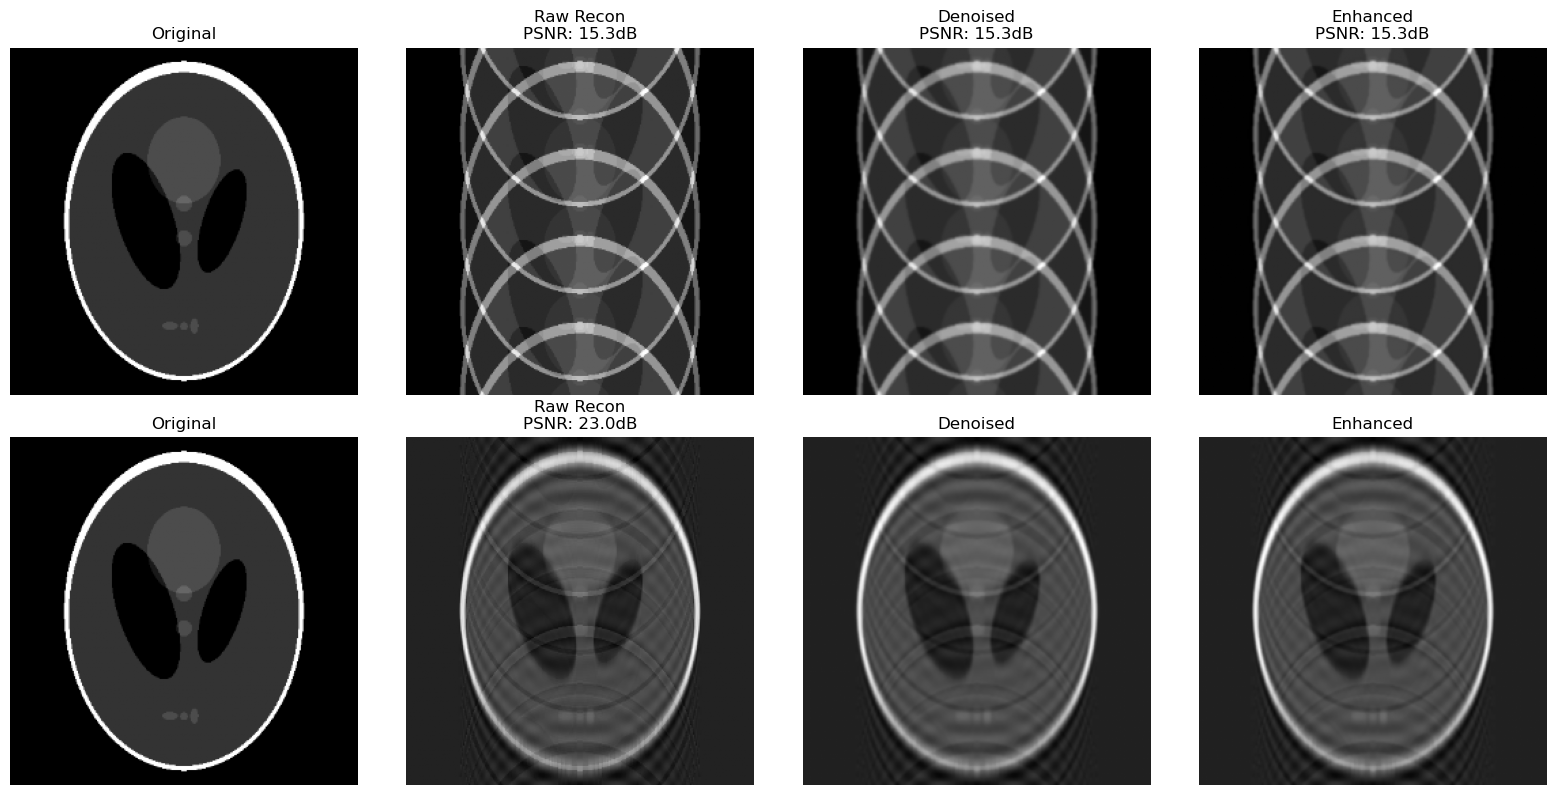

✓ 图像域后处理完成


In [9]:
# 对欠采样重建结果进行去噪
denoised_line = gaussian_filter(recon_line, sigma=0.8)
denoised_center = gaussian_filter(recon_center, sigma=0.8)

# 边缘增强（反锐化掩模）
def unsharp_mask(image, sigma=1.0, strength=0.5):
    """反锐化掩模增强"""
    blurred = gaussian_filter(image, sigma=sigma)
    mask = image - blurred
    return image + strength * mask

enhanced_line = unsharp_mask(denoised_line, sigma=1.0, strength=0.3)
enhanced_center = unsharp_mask(denoised_center, sigma=1.0, strength=0.3)

# 计算质量指标
psnr_denoised_line = peak_signal_noise_ratio(img, denoised_line, data_range=1.0)
psnr_enhanced_line = peak_signal_noise_ratio(img, enhanced_line, data_range=1.0)

ssim_denoised_line = structural_similarity(img, denoised_line, data_range=1.0)
ssim_enhanced_line = structural_similarity(img, enhanced_line, data_range=1.0)

# 可视化
fig, axes = plt.subplots(2, 4, figsize=(16, 8))

# 行欠采样
axes[0, 0].imshow(img, cmap='gray')
axes[0, 0].set_title('Original')
axes[0, 0].axis('off')

axes[0, 1].imshow(recon_line, cmap='gray')
axes[0, 1].set_title(f'Raw Recon\nPSNR: {psnr_line:.1f}dB')
axes[0, 1].axis('off')

axes[0, 2].imshow(denoised_line, cmap='gray')
axes[0, 2].set_title(f'Denoised\nPSNR: {psnr_denoised_line:.1f}dB')
axes[0, 2].axis('off')

axes[0, 3].imshow(enhanced_line, cmap='gray')
axes[0, 3].set_title(f'Enhanced\nPSNR: {psnr_enhanced_line:.1f}dB')
axes[0, 3].axis('off')

# 中心采样
axes[1, 0].imshow(img, cmap='gray')
axes[1, 0].set_title('Original')
axes[1, 0].axis('off')

axes[1, 1].imshow(recon_center, cmap='gray')
axes[1, 1].set_title(f'Raw Recon\nPSNR: {psnr_center:.1f}dB')
axes[1, 1].axis('off')

axes[1, 2].imshow(denoised_center, cmap='gray')
axes[1, 2].set_title('Denoised')
axes[1, 2].axis('off')

axes[1, 3].imshow(enhanced_center, cmap='gray')
axes[1, 3].set_title('Enhanced')
axes[1, 3].axis('off')

plt.tight_layout()
plt.savefig('output/07_postprocessing.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ 图像域后处理完成")

## 9. 不同采样率对比分析

分析不同采样率对重建质量的影响。

In [10]:
# 测试不同采样率
sampling_factors = [2, 4, 6, 8, 10]
results = []

for factor in sampling_factors:
    # 创建采样掩码
    mask = create_line_undersampling_mask(img_size, factor)
    k_us = k_space * mask
    
    # 零填充重建
    recon_zf = np.real(np.fft.ifft2(np.fft.ifftshift(k_us)))
    
    # POCS重建
    recon_pocs = pocs_reconstruction(k_us, mask, n_iterations=20)
    
    # 计算指标
    rate = np.sum(mask) / mask.size * 100
    psnr_zf = peak_signal_noise_ratio(img, recon_zf, data_range=1.0)
    psnr_pocs = peak_signal_noise_ratio(img, recon_pocs, data_range=1.0)
    ssim_zf = structural_similarity(img, recon_zf, data_range=1.0)
    ssim_pocs = structural_similarity(img, recon_pocs, data_range=1.0)
    
    results.append({
        'factor': factor,
        'rate': rate,
        'psnr_zf': psnr_zf,
        'psnr_pocs': psnr_pocs,
        'ssim_zf': ssim_zf,
        'ssim_pocs': ssim_pocs,
        'recon_zf': recon_zf,
        'recon_pocs': recon_pocs
    })

print("✓ 不同采样率测试完成")

✓ 不同采样率测试完成


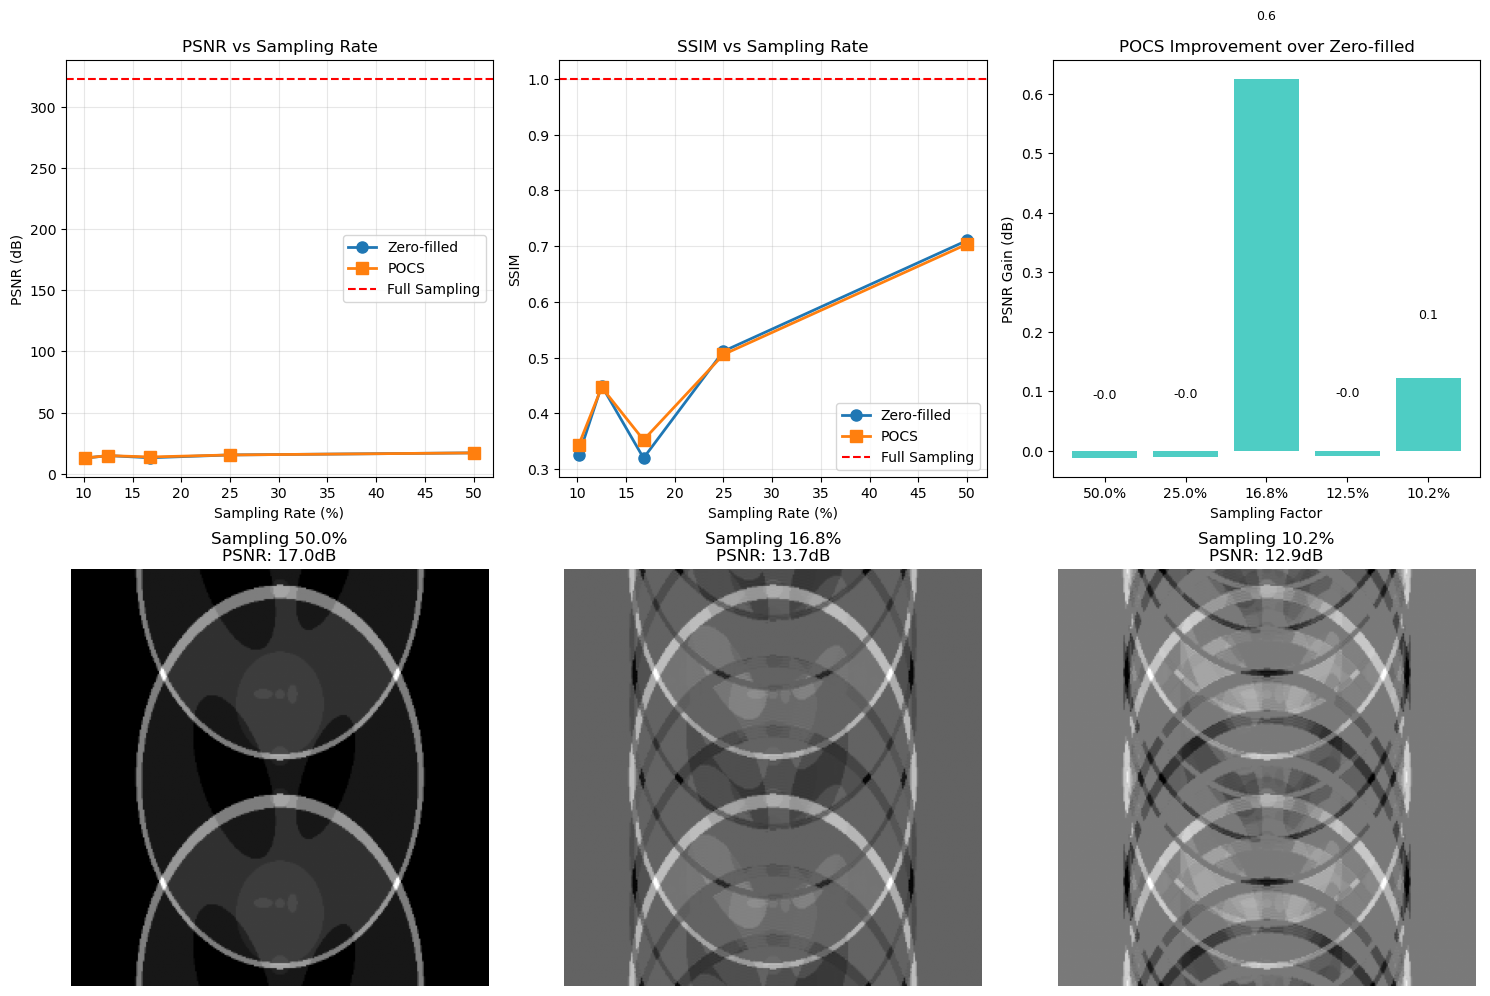

✓ 采样率分析可视化完成


In [11]:
# 可视化对比结果
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

rates = [r['rate'] for r in results]
psnrs_zf = [r['psnr_zf'] for r in results]
psnrs_pocs = [r['psnr_pocs'] for r in results]
ssims_zf = [r['ssim_zf'] for r in results]
ssims_pocs = [r['ssim_pocs'] for r in results]

# PSNR对比
axes[0, 0].plot(rates, psnrs_zf, 'o-', label='Zero-filled', linewidth=2, markersize=8)
axes[0, 0].plot(rates, psnrs_pocs, 's-', label='POCS', linewidth=2, markersize=8)
axes[0, 0].axhline(y=psnr_full, color='r', linestyle='--', label='Full Sampling')
axes[0, 0].set_xlabel('Sampling Rate (%)')
axes[0, 0].set_ylabel('PSNR (dB)')
axes[0, 0].set_title('PSNR vs Sampling Rate')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# SSIM对比
axes[0, 1].plot(rates, ssims_zf, 'o-', label='Zero-filled', linewidth=2, markersize=8)
axes[0, 1].plot(rates, ssims_pocs, 's-', label='POCS', linewidth=2, markersize=8)
axes[0, 1].axhline(y=ssim_full, color='r', linestyle='--', label='Full Sampling')
axes[0, 1].set_xlabel('Sampling Rate (%)')
axes[0, 1].set_ylabel('SSIM')
axes[0, 1].set_title('SSIM vs Sampling Rate')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# PSNR提升
psnr_gain = [pocs - zf for pocs, zf in zip(psnrs_pocs, psnrs_zf)]
axes[0, 2].bar(range(len(rates)), psnr_gain, color='#4ECDC4')
axes[0, 2].set_xlabel('Sampling Factor')
axes[0, 2].set_ylabel('PSNR Gain (dB)')
axes[0, 2].set_title('POCS Improvement over Zero-filled')
axes[0, 2].set_xticks(range(len(rates)))
axes[0, 2].set_xticklabels([f'{r:.1f}%' for r in rates])
for i, v in enumerate(psnr_gain):
    axes[0, 2].text(i, v + 0.1, f'{v:.1f}', ha='center', fontsize=9)

# 显示不同采样率的重建结果（选择3个代表性采样率）
selected_indices = [0, 2, 4]  # 2x, 6x, 10x
for idx, sel_idx in enumerate(selected_indices):
    r = results[sel_idx]
    axes[1, idx].imshow(r['recon_pocs'], cmap='gray')
    axes[1, idx].set_title(f"Sampling {r['rate']:.1f}%\nPSNR: {r['psnr_pocs']:.1f}dB")
    axes[1, idx].axis('off')

plt.tight_layout()
plt.savefig('output/08_sampling_rate_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ 采样率分析可视化完成")

## 10. 完整重建流程对比

对比不同重建方法的效果。

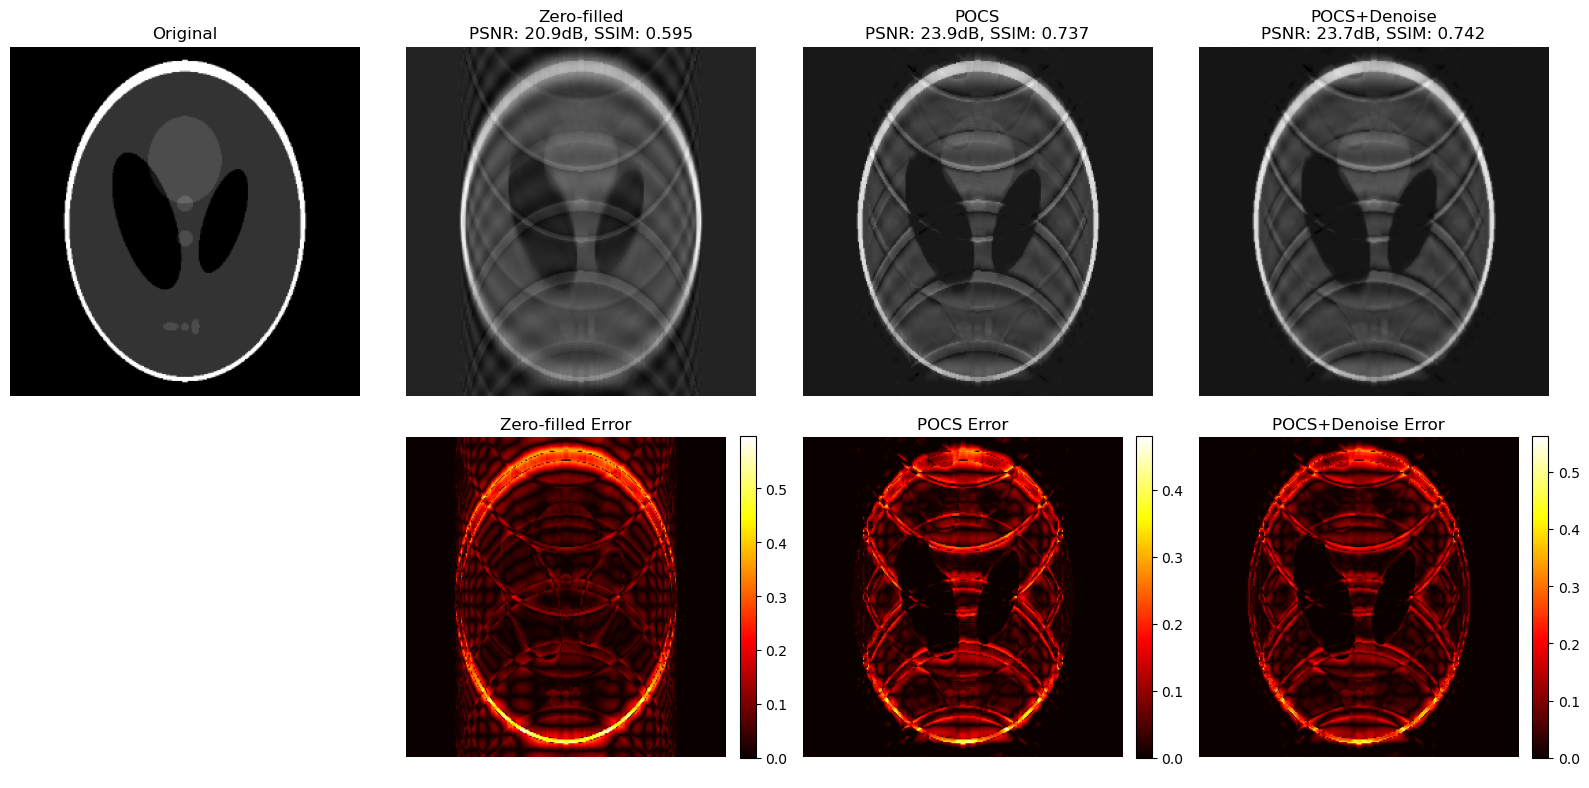


重建方法对比（25%采样率）：
Method               PSNR (dB)    SSIM       NMSE      
------------------------------------------------------------
Zero-filled          20.92        0.5949     0.137619  
POCS                 23.95        0.7374     0.068569  
POCS+Denoise         23.67        0.7423     0.073120  


In [12]:
# 选择中心采样25%进行详细对比
mask_25 = create_center_sampling_mask(img_size, 20, 5)
k_25 = k_space * mask_25

# 不同重建方法
recon_zf = np.real(np.fft.ifft2(np.fft.ifftshift(k_25)))
recon_pocs = pocs_reconstruction(k_25, mask_25, n_iterations=30)
recon_denoised = gaussian_filter(recon_pocs, sigma=0.5)

# 计算指标
methods = ['Zero-filled', 'POCS', 'POCS+Denoise']
recons = [recon_zf, recon_pocs, recon_denoised]

metrics = []
for recon in recons:
    psnr = peak_signal_noise_ratio(img, recon, data_range=1.0)
    ssim = structural_similarity(img, recon, data_range=1.0)
    nmse = np.mean((img - recon)**2) / np.mean(img**2)
    metrics.append({'psnr': psnr, 'ssim': ssim, 'nmse': nmse})

# 可视化
fig, axes = plt.subplots(2, 4, figsize=(16, 8))

# 第一行：重建结果
axes[0, 0].imshow(img, cmap='gray')
axes[0, 0].set_title('Original')
axes[0, 0].axis('off')

for i, (method, recon, metric) in enumerate(zip(methods, recons, metrics)):
    axes[0, i+1].imshow(recon, cmap='gray')
    axes[0, i+1].set_title(f'{method}\nPSNR: {metric["psnr"]:.1f}dB, SSIM: {metric["ssim"]:.3f}')
    axes[0, i+1].axis('off')

# 第二行：误差分析
axes[1, 0].axis('off')

for i, (method, recon) in enumerate(zip(methods, recons)):
    error = np.abs(img - recon)
    im = axes[1, i+1].imshow(error, cmap='hot')
    axes[1, i+1].set_title(f'{method} Error')
    axes[1, i+1].axis('off')
    plt.colorbar(im, ax=axes[1, i+1], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.savefig('output/09_method_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

# 打印指标对比表
print("\n重建方法对比（25%采样率）：")
print("="*60)
print(f"{'Method':<20} {'PSNR (dB)':<12} {'SSIM':<10} {'NMSE':<10}")
print("-"*60)
for method, metric in zip(methods, metrics):
    print(f"{method:<20} {metric['psnr']:<12.2f} {metric['ssim']:<10.4f} {metric['nmse']:<10.6f}")
print("="*60)

## 11. 总结报告

In [13]:
print("="*70)
print("MRI重建流程总结报告")
print("="*70)
print()
print("1. 基础参数：")
print(f"   - 图像大小: {img_size}x{img_size}")
print(f"   - 完全采样基准 PSNR: {psnr_full:.2f} dB")
print()
print("2. 采样策略对比（25%采样率）：")
print(f"   - 行欠采样 PSNR: {psnr_line:.2f} dB")
print(f"   - 中心优先 PSNR: {psnr_center:.2f} dB")
print(f"   - 径向采样 PSNR: {psnr_radial:.2f} dB")
print()
print("3. 重建算法效果（POCS vs 零填充）：")
print(f"   - 零填充 PSNR: {psnr_line:.2f} dB")
print(f"   - POCS重建 PSNR: {psnr_pocs_line:.2f} dB")
print(f"   - 提升幅度: {psnr_pocs_line - psnr_line:.2f} dB")
print()
print("4. 处理步骤：")
print("   ✓ K空间基础（FFT/IFFT）")
print("   ✓ 完全采样重建")
print("   ✓ 多种采样策略（行/中心/径向）")
print("   ✓ 欠采样伪影分析")
print("   ✓ POCS迭代重建")
print("   ✓ K空间滤波")
print("   ✓ 图像域后处理")
print("   ✓ 采样率对比分析")
print("   ✓ 方法对比评估")
print()
print("5. 输出文件：")
print("   - output/01_kspace_basics.png")
print("   - output/02_full_sampling_recon.png")
print("   - output/03_sampling_masks.png")
print("   - output/04_undersampling_artifacts.png")
print("   - output/05_pocs_reconstruction.png")
print("   - output/06_kspace_filtering.png")
print("   - output/07_postprocessing.png")
print("   - output/08_sampling_rate_analysis.png")
print("   - output/09_method_comparison.png")
print()
print("="*70)
print("MRI重建流程执行完成！")
print("="*70)

MRI重建流程总结报告

1. 基础参数：
   - 图像大小: 256x256
   - 完全采样基准 PSNR: 322.69 dB

2. 采样策略对比（25%采样率）：
   - 行欠采样 PSNR: 15.33 dB
   - 中心优先 PSNR: 23.03 dB
   - 径向采样 PSNR: 19.29 dB

3. 重建算法效果（POCS vs 零填充）：
   - 零填充 PSNR: 15.33 dB
   - POCS重建 PSNR: 15.31 dB
   - 提升幅度: -0.01 dB

4. 处理步骤：
   ✓ K空间基础（FFT/IFFT）
   ✓ 完全采样重建
   ✓ 多种采样策略（行/中心/径向）
   ✓ 欠采样伪影分析
   ✓ POCS迭代重建
   ✓ K空间滤波
   ✓ 图像域后处理
   ✓ 采样率对比分析
   ✓ 方法对比评估

5. 输出文件：
   - output/01_kspace_basics.png
   - output/02_full_sampling_recon.png
   - output/03_sampling_masks.png
   - output/04_undersampling_artifacts.png
   - output/05_pocs_reconstruction.png
   - output/06_kspace_filtering.png
   - output/07_postprocessing.png
   - output/08_sampling_rate_analysis.png
   - output/09_method_comparison.png

MRI重建流程执行完成！
